# Exploring Machine Intelligence Week 4 _ 3. building a version of Mario Klingemann's "X Degrees of Separation" of QuickDraw

## Experiments with Image Autoencoders 

***Note 1***

This notebook was originally written by Vit for the 2020 offering of Exploring Machine Intelligence. Vit in turn borrowed heavily from [https://blog.keras.io/building-autoencoders-in-keras.html](https://blog.keras.io/building-autoencoders-in-keras.html)

***Note 2***

It is strongly recommended to run this on colab.google.com if you do not have a GPU.


# Step 0: Set everything up

In [4]:
# Run this code without any changes
# Basic imports

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils.vis_utils import plot_model
from keras import backend as K

from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from keras.layers import Reshape, Flatten, BatchNormalization, Activation

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Step 1: Load the data using Option 1 or Option 2 below. (Start with Option 1, then move onto Step 2)


### Option 2: Use QuickDraw (Do this only after you've done MNIST)

We can also use the QuickDraw [dataset](https://github.com/googlecreativelab/quickdraw-dataset) by [@Zaid Alyafeai](https://twitter.com/zaidalyafeai) which was used in the [ML4A guide](https://ml4a.github.io/guides/) for regular AutoEncoder.

In [5]:
!git clone https://github.com/zaidalyafeai/QuickDraw10

Cloning into 'QuickDraw10'...
remote: Enumerating objects: 53, done.
remote: Total 53 (delta 0), reused 0 (delta 0), pack-reused 53
Unpacking objects: 100% (53/53), done.


In [6]:
import numpy as np

train_data = np.load('QuickDraw10/dataset/train-ubyte.npz')
test_data = np.load('QuickDraw10/dataset/test-ubyte.npz')

x_train, y_train = train_data['a'], test_data['b']
x_test,  y_test  = test_data['a'],  test_data['b']

In [7]:
x_train = np.expand_dims(x_train.astype('float32') / 255. , 3)
x_test = np.expand_dims(x_test.astype('float32') / 255. , 3)
print (x_train.shape)
print (x_test.shape)

(80000, 28, 28, 1)
(20000, 28, 28, 1)


(28, 28, 1) stats: 1.0 0.0 0.8601641


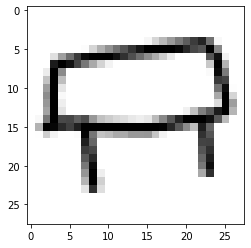

In [9]:
# Let's look at one sample:
x1 = x_test[336] # 0 - umbrella
print(x1.shape, "stats:", np.max(x1), np.min(x1), np.mean(x1))

plt.figure(figsize=(4,4))
plt.imshow(x1[:,:,0], cmap='gray', vmin=0.0, vmax=1.0)
plt.show()

**Now that you've loaded the data, you can re-run the rest of the notebook to build a model, interpolate, etc!**

# Step 2: Now that you've loaded data (either MNIST or QuickDraw), do this to build the model:

Ensure that you've chosen either the MNIST or QuickDraw dataset above, and the dataset you want is now loaded into `x_train` and `x_test`.

This code builds a model using a standard convolutional autoencoder architecture:

Image -> Encoder -> latent vector representation -> Decoder -> Reconstruction

In [10]:
# network parameters
input_shape = (28, 28, 1)
latent_dim = 128 #you might play with changing this

# VAE model = encoder + decoder

# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')

kernels = 128 #you could change this too

x = Conv2D(int(kernels/8), (3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2), padding='same')(x)
x = Conv2D(int(kernels/4), (3), activation='relu', padding='same')(x)
x = MaxPooling2D((2), padding='same')(x)
x = Conv2D(int(kernels/1), (3), activation='relu', padding='same')(x)
x = MaxPooling2D((2), padding='same')(x)
intermediate_conv_shape = x.get_shape()
x = Flatten()(x)

# optionally BN?
x = BatchNormalization()(x)
x = Activation("relu")(x)

_,n,m,o = intermediate_conv_shape # (None, 4, 4, 6) # 96
intermediate_dim = n*m*o

#some fully connected layers in the middle?
#x = Dense(intermediate_dim, activation='relu')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)

# optionally BN?
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Reshape((n,m,o))(x)
x = Conv2D(int(kernels/1), (3), activation='relu', padding='same')(x)
x = UpSampling2D((2))(x)
x = Conv2D(int(kernels/4), (3), activation='relu', padding='same')(x)
x = UpSampling2D((2))(x)
x = Conv2D(int(kernels/8), (3), activation='relu')(x)
x = UpSampling2D((2))(x)
outputs = Conv2D(1, (3), activation='sigmoid', padding='same')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [11]:
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 16)   160         ['encoder_input[0][0]']          
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 14, 14, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 32)   4640        ['max_pooling2d[0][0]']          
                                                                                            

In [12]:
models = (encoder, decoder)
data = (x_test, y_test)

args_mse = False
# VAE loss = mse_loss or xent_loss + kl_loss
if args_mse:
    reconstruction_loss = mse(inputs, outputs)
else:
    reconstruction_loss = binary_crossentropy(inputs, outputs)

m = input_shape[0]*input_shape[1]
reconstruction_loss *= m # 28x28 values
reconstruction_loss = K.sum(reconstruction_loss)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae_loss /= m
vae_loss /= m
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 128),        574528      ['encoder_input[0][0]']          
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                                  
 decoder (Functional)           (None, 28, 28, 1)    461633      ['encoder[0][2]']                
                                                                                            

In [13]:
batch_size = 128
epochs = 20

#history = vae.fit(x_train[0:1000], epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(x_test, None))
history = vae.fit(x_train, epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/20
625/625 [==============================] - 20s 12ms/step - loss: 29.0772 - val_loss: 34.4957
Epoch 2/20
625/625 [==============================] - 7s 11ms/step - loss: 21.5570 - val_loss: 21.9548
Epoch 3/20
625/625 [==============================] - 7s 11ms/step - loss: 19.8261 - val_loss: 20.2580
Epoch 4/20
625/625 [==============================] - 7s 11ms/step - loss: 18.8990 - val_loss: 18.7845
Epoch 5/20
625/625 [==============================] - 7s 11ms/step - loss: 18.3120 - val_loss: 18.3437
Epoch 6/20
625/625 [==============================] - 7s 11ms/step - loss: 17.9113 - val_loss: 17.8126
Epoch 7/20
625/625 [==============================] - 7s 11ms/step - loss: 17.6188 - val_loss: 17.6524
Epoch 8/20
625/625 [==============================] - 7s 11ms/step - loss: 17.3675 - val_loss: 17.2940
Epoch 9/20
625/625 [==============================] - 7s 11ms/step - loss: 17.1612 - val_loss: 17.3094
Epoch 10/20
625/625 [==============================] - 7s 11ms/step - lo

Plot:


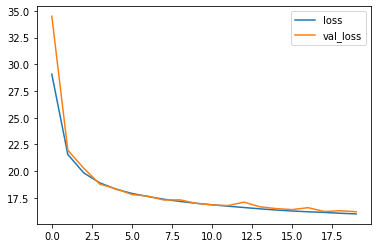

In [14]:
# How did we go?
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_array = list(range(epochs))
plt.plot(epochs_array, loss, label="loss")
plt.plot(epochs_array, val_loss, label="val_loss")
plt.legend()

print("Plot:")

In [15]:
import json

def save_model(model, name):
    model_json = model.to_json()
    with open(name+".json", "w") as json_file:
        json.dump(model_json, json_file)

    model.save_weights(name+".h5")

#you might want to give your model an understandable filename
#save_model(encoder,'encoder_mnist')
#save_model(decoder,'decoder_mnist')
save_model(encoder,'encoder_draw_10ep')
save_model(decoder,'decoder_draw_10ep')

## Now let's use it!

In [16]:
# We can carry these files (*.h5, *.json) somewhere else ...
from keras.models import load_model
from keras.models import model_from_json
import json
def my_load_model(name):
    with open(name+'.json','r') as f:
        model_json = json.load(f)

    model = model_from_json(model_json)
    model.load_weights(name+'.h5')
    return model

#Use same filename as above here
#decoder = my_load_model('decoder_mnist')
#encoder = my_load_model('encoder_mnist')
#decoder = my_load_model('decoder_draw_10ep')
#encoder = my_load_model('encoder_draw_10ep')
decoder = my_load_model('decoder_draw_10ep')
encoder = my_load_model('encoder_draw_10ep')

## Inspect one in detail:

(28, 28, 1)
1.0 0.0 0.7602241


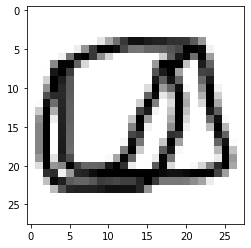

In [17]:
# Encoded image:

x1 = x_test[286] # number 73 picked for no reason at all
print(x1.shape)
print(np.max(x1), np.min(x1), np.mean(x1))

img = x1[:,:,0]

plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray', vmin=0.0, vmax=1.0)
plt.show()

(1, 128)
11.768119 -17.228134 -1.3413386


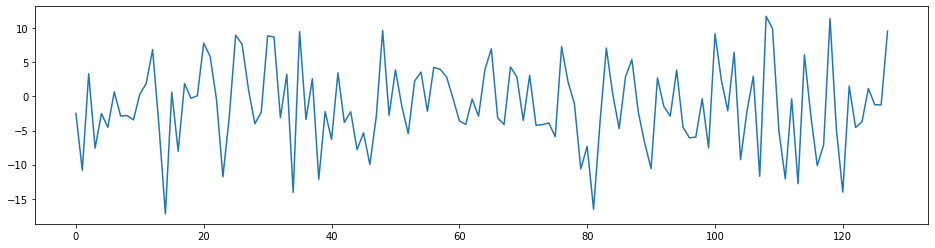

In [18]:
# Latent vector:

x1_arr = np.asarray([x1])
z, z_mean, z_log_var = encoder.predict(x1_arr)
print(z.shape)
print(np.max(z), np.min(z), np.mean(z))

plt.figure(figsize=(16,4))
plt.plot(z[0])
plt.show()

#Plotting is not particularly informative here, it's just a set of 32 numbers, but why not?

(1, 28, 28, 1)


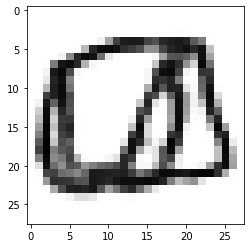

In [19]:
# Reconstructed image

y1 = decoder.predict(z)
print(y1.shape)
y1 = y1[0]

img = y1[:,:,0]

plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray', vmin=0.0, vmax=1.0)
plt.show()


## Or in triplets:

In [ ]:
def plot_tripple(image, vector, reconstruction):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle('Image > Representation > Reconstruction')
    ax1.imshow(image, cmap='gray', vmin=0.0, vmax=1.0)
    ax2.plot(vector)
    ax2.set_aspect(3.1)
    ax3.imshow(reconstruction, cmap='gray', vmin=0.0, vmax=1.0)

def plot_single(image):
    plt.figure(figsize=(1,1))
    plt.imshow(image, cmap='gray', vmin=0.0, vmax=1.0)
    plt.show()

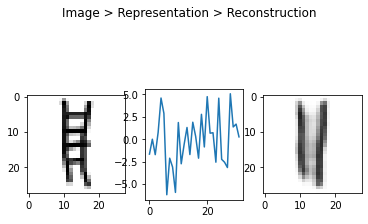

In [ ]:
x1 = x_test[9] # Randomly pick 9th image from test set
z, z_mean, z_log_var = encoder.predict(np.asarray([x1])) 
y1 = decoder.predict(z)

plot_tripple(x1[:,:,0], z[0], y1[0,:,:,0])

### Look at a few randomly selected images and compare original, latent vector, and reconstruction

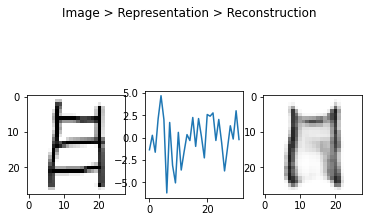

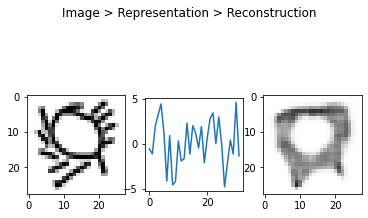

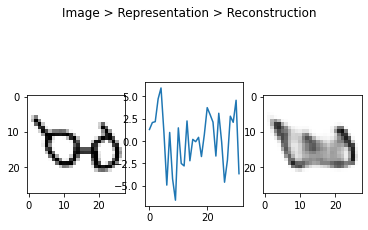

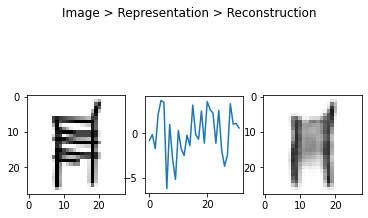

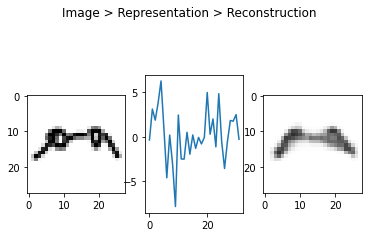

In [ ]:
from random import randrange
for i in range(5):
    x1 = x_test[randrange(len(x_test))]
    z, z_mean, z_log_var = encoder.predict(np.asarray([x1]))
    y1 = decoder.predict(z)
    plot_tripple(x1[:,:,0], z[0], y1[0,:,:,0])

### Show interpolation/moprhing between two images

z_sample_a_encoded: (1, 32)
z_sample_b_encoded: (1, 32)


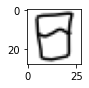

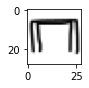

In [ ]:
sample_a = x_test[2] 
z_sample_a_encoded, _, _ = encoder.predict(np.asarray([sample_a]))

sample_b = x_test[3] 
z_sample_b_encoded, _, _ = encoder.predict(np.asarray([sample_b]))

print("z_sample_a_encoded:", z_sample_a_encoded.shape)
print("z_sample_b_encoded:", z_sample_b_encoded.shape)

#Let's show both original images 
plot_single(sample_a.reshape((28,28)))
plot_single(sample_b.reshape((28,28)))

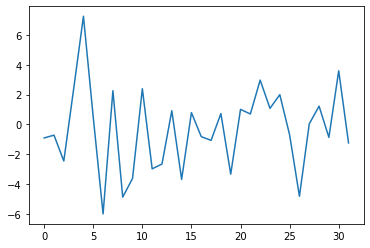

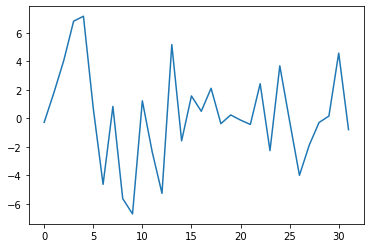

In [ ]:
# Show the latent vectors for each image
plt.plot(z_sample_a_encoded[0])
plt.show()
plt.plot(z_sample_b_encoded[0])
plt.show()

In [ ]:
# Define a function to linearly interpolate from one latent vector for another,
# specifically a*100% of the way there (i.e., if a=0.25, then we'll be 25% of the way from a to b)
def lerp(u,v,a):
    # linear interpolation between vectors u and v
    return a*u + (1-a)*v

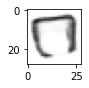

In [ ]:
a = 0.5  #show one image halfway between a and b
z_mix = lerp(z_sample_a_encoded, z_sample_b_encoded, a)
image = decoder.predict(z_mix) # shape comes as (1,28,28,1)
image = image.reshape((28,28))

plot_single(image)

0.0 :


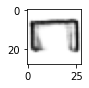

0.2 :


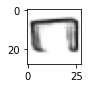

0.4 :


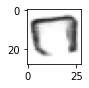

0.6 :


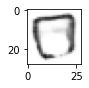

0.8 :


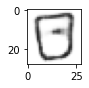

1.0 :


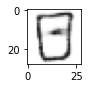

In [ ]:
# Now interpolate in a set number of steps
steps = 5
for i in range(steps + 1):
    # Goes from 0.0 to 1.0 in <steps> steps
    a_01 = float(i) / float(steps)
    z_mix = lerp(z_sample_a_encoded, z_sample_b_encoded, a_01)
    y = decoder.predict(z_mix)
    image = y.reshape((28,28))
    print(a_01,":")
    plot_single(image)

## Produce a new image from a completely random latent vector

latent =  [[-4.07602231e+00  2.83167039e+00 -3.18532941e+00 -3.49759868e+00
  -9.92956591e-01  2.40504922e+00  4.29981404e+00 -4.80178055e+00
  -6.48918102e+00  1.04908366e+00  3.05672439e+00  7.37255397e+00
   5.88135798e-01 -4.69422018e+00 -6.07027783e-02 -8.41896065e-03
  -5.26209455e-03  9.15897178e+00  3.55358128e+00 -8.73485580e-01
  -4.56553853e+00  9.39973094e-01 -3.31234346e+00  2.44792494e+00
  -4.44252450e+00  7.38340697e-01  6.29823879e+00 -4.12244624e+00
   1.96788250e+00 -3.78668013e+00 -3.07805030e+00 -2.28804286e+00]]


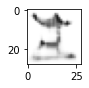

In [ ]:
# Random latent
latent = np.random.randn(1, 32) * 5
print("latent = ",latent)

image = decoder.predict(latent)
image = image.reshape((28,28))

plot_single(image)

latent =  [999.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.]


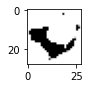

In [ ]:
# We can try to break it ...

latent = np.zeros(32)
latent[0] = 999.0 # oversaturated?
print("latent = ",latent)

image = decoder.predict(latent.reshape(1,32))
image = image.reshape((28,28))

plot_single(image)

## (Or) visualization as a gif:

As a bonus including a visualization from https://github.com/zaidalyafeai/Notebooks/blob/master/AutoEncoders.ipynb

First, you'll need to install `imageio` and `opencv-python` modules using pip or conda (see moodle instructions)

In [ ]:
import shutil 
import cv2
import imageio, glob

#linear interpolation function 
def f(x):
  return x

def interpolate(size = 10):
  if os.path.exists("images"):
    shutil.rmtree("images")
    os.makedirs('images')
  else:
    os.makedirs('images')
    
  
  
  #get 3 random batches each of size 3 
  batches = []
  for _ in range(0, 3):
    i1 = np.random.randint(0, len(x_train))
    i2 = np.random.randint(0, len(x_train))
    batches.append([x_train[i1:i1+3], x_train[i2:i2+3]])
 
  i = 0   
  for x in list(np.linspace(0, 1, size)):
    frame = None
    j = 0 
    
    #interpolate each batch and concatenate them at the end to create 3x3 images
    for (x1, x2) in batches:
    
      
      v1,_,_ = encoder.predict(x1) 
      v2,_,_ = encoder.predict(x2)
        
      #use a linear interpolater
      v = (float(x))*v1 + (1.0 - float(x))*v2
      
      #get the output and reshape it 
      y = decoder.predict(v)
      img = np.reshape(y, (3 * 28, 28))
      img = img * 255
      
      #concatenate the batches 
      if frame is None:
        frame = img
      else:
        frame = np.concatenate([frame, img], axis = 1)
      j += 1
      
    #write the current frame to the disk 
    frame = cv2.resize(frame, (256, 256))  
    cv2.imwrite(f'images/image{i}.png', frame)
    i+=1

In [ ]:
!mkdir images
!ls images

mkdir: cannot create directory ‘images’: File exists
image0.png  image2.png	image4.png  image6.png	image8.png
image1.png  image3.png	image5.png  image7.png	image9.png


In [ ]:
interpolate(size = 10)

with imageio.get_writer('lsi.gif', mode='I', duration=0.35) as writer:
  filenames = glob.glob('images/image*.png')
  filenames = sorted(filenames)
  
  for i,filename in enumerate(filenames):
    image = imageio.imread(filename)
    writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
os.system('cp lsi.gif lsi.gif.png')

0

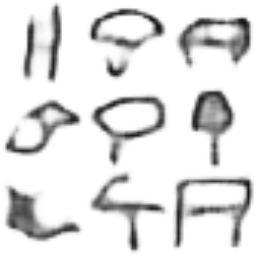

In [ ]:
from IPython import display 
display.Image(filename="lsi.gif.png")

## Activities to do on your own

3. (More difficult) Try building a version of Mario Klingemann's "X Degrees of Separation" for a dataset (could be MNIST or QuickDraw or something else). Write the code to select 5 (or some other number) of existing images that follow a smooth (as smooth as possible) path through latent space between two chosen images.

In [21]:
import  os
import  tensorflow as tf
import  numpy as np
from    tensorflow import keras
from    tensorflow.keras import Sequential, layers
from    PIL import Image
from    matplotlib import pyplot as plt

In [20]:
x_train.shape

(80000, 28, 28, 1)

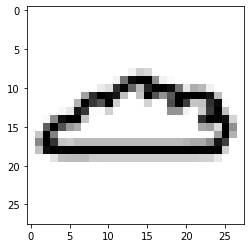

In [22]:
plt.imshow(x_train[79,:,:,0],cmap='gray')

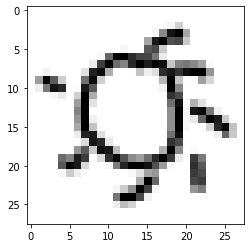

In [23]:
plt.imshow(x_train[461,:,:,0],cmap='gray')

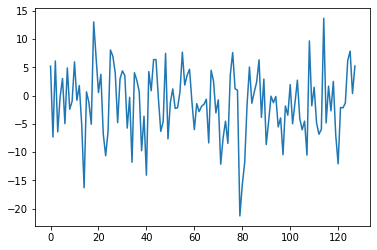

In [27]:
sample_1 = x_test[79] 
z_1, _, _ = encoder.predict(np.expand_dims(sample_a,axis=0))
plt.plot(z_1[0])

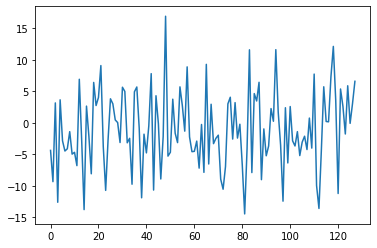

In [28]:
sample_2 = x_test[461] 
z_2, _, _ = encoder.predict(np.expand_dims(sample_b,axis=0))
plt.plot(z_2[0])

In [29]:
from scipy.spatial import distance

distance.euclidean(z_1,z_2)

61.005008697509766

In [30]:
z_mid = (z_1 + z_2)/2

In [31]:
z_mid

array([[  0.43026924,  -8.316931  ,   4.655259  ,  -9.4976845 ,
          1.7445548 ,   0.10165095,  -4.7051325 ,   0.40165663,
         -1.8971939 ,  -2.9662921 ,   0.6574297 ,  -3.7948961 ,
          4.3539906 ,  -3.9691193 , -15.020248  ,   1.669111  ,
         -1.6572983 ,  -6.565537  ,   9.738306  ,   4.8160152 ,
          2.297761  ,   6.432453  ,  -5.264457  , -10.662909  ,
         -4.4832735 ,   5.957343  ,   5.0006876 ,   2.2525716 ,
         -2.3615773 ,  -0.05528927,   5.023036  ,   4.273513  ,
         -4.4470434 ,  -1.3613652 , -10.757334  ,   4.49829   ,
          4.201795  ,  -0.06493095, -10.807071  ,  -2.710437  ,
         -9.414487  ,   1.8963227 ,   4.341436  ,  -2.1343453 ,
          5.34962   ,  -0.29220873,  -7.6045227 ,  -3.3485255 ,
         12.201156  ,  -6.45907   ,  -2.9136603 ,   2.4786565 ,
         -1.9456677 ,  -2.6273198 ,   3.163462  ,   5.2095647 ,
          0.2854147 ,   6.2646074 ,   1.2311171 ,  -2.8346367 ,
         -5.25803   ,  -2.147986  ,  -4.

In [32]:
z_data, _, _ = encoder(x_train[:15000])

In [38]:
from math import ceil

sample_sel = [79,461]

sequence = np.zeros((5,)).astype(int)
sequence[0] = sample_sel[0]
sequence[-1] = sample_sel[1]

In [39]:
sample_sel=[79,461]

distances = np.zeros((z_data.shape[0],))

for i, z_this in enumerate(z_data):
  dist = distance.euclidean(z_mid, z_this)
  distances[i] = dist
  if i in sequence:
    distances[i] = 100

In [40]:
np.argmin(distances)

7016

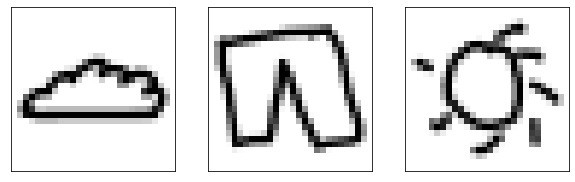

In [41]:
sequence = [79, 7016, 461]

plt.figure(figsize=(10,6))
for i in range(len(sequence)):
    plt.subplot(1,len(sequence),i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[sequence[i]][:,:,0], cmap='gray')
plt.show()

In [42]:
sample_sel=[79,7016]

distances = np.zeros((z_data.shape[0],))

for i, z_this in enumerate(z_data):
  dist = distance.euclidean(z_mid, z_this)
  distances[i] = dist
  if i in sequence:
    distances[i] = 100

In [43]:
np.argmin(distances)

3236

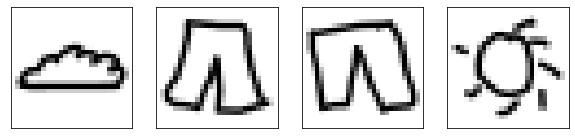

In [44]:
sequence = [79, 3236, 7016, 461]

plt.figure(figsize=(10,6))
for i in range(len(sequence)):
    plt.subplot(1,len(sequence),i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[sequence[i]][:,:,0], cmap='gray')
plt.show()

In [45]:
sample_sel=[7016,461]

distances = np.zeros((z_data.shape[0],))

for i, z_this in enumerate(z_data):
  dist = distance.euclidean(z_mid, z_this)
  distances[i] = dist
  if i in sequence:
    distances[i] = 100

In [46]:
np.argmin(distances)

7073

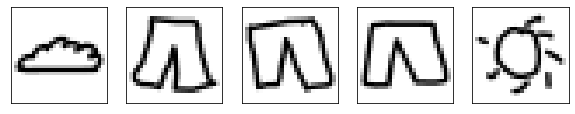

In [47]:
sequence = [79, 3236, 7016, 7073, 461]

plt.figure(figsize=(10,6))
for i in range(len(sequence)):
    plt.subplot(1,len(sequence),i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[sequence[i]][:,:,0], cmap='gray')
plt.show()

In [54]:
sample_sel = [79,461]

sequence = np.zeros((9,)).astype(int)
sequence[0] = sample_sel[0]
sequence[-1] = sample_sel[1]

In [59]:
def find_sequence(sequence,z_data):
  lens = len(sequence)

  if lens==2:
    return sequence
  
  # calculate middle
  z_mid = (z_data[sequence[0]] + z_data[sequence[-1]])/2

  # find closest x_train
  distances = np.zeros((z_data.shape[0],))

  for i, z_this in enumerate(z_data):
    dist = distance.euclidean(z_mid, z_this)
    distances[i] = dist
    if i in sequence:
      distances[i] = 100

  # sequence middle index = argmin()
  sequence[int(lens/2)] = np.argmin(distances)

  first_half = find_sequence(sequence[:ceil(lens/2)],z_data)
  second_half = find_sequence(sequence[-ceil(lens/2):], z_data)

  merge = np.concatenate((first_half,second_half[1:]),axis=0)
  print(merge)

  return merge


In [56]:
sample_fin = find_sequence(sequence,z_data)

[  79 3455 4630]
[ 4630 14302  3980]
[   79  3455  4630 14302  3980]
[ 3980  4630 14302]
[14302  3980   461]
[ 3980  4630 14302  3980   461]
[   79  3455  4630 14302  3980  4630 14302  3980   461]


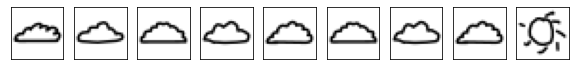

In [61]:
sequence = [79, 3455, 4630, 14302, 3980, 4630, 14302, 3980, 461]

plt.figure(figsize=(10,6))
for i in range(len(sequence)):
    plt.subplot(1,len(sequence),i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[sequence[i]][:,:,0], cmap='gray')
plt.show()

In [58]:
sample_sel = [1277,25]

sequence = np.zeros((9,)).astype(int)
sequence[0] = sample_sel[0]
sequence[-1] = sample_sel[1]

In [60]:
sample_fin = find_sequence(sequence,z_data)

[ 1277   820 13549]
[13549  1277   820]
[ 1277   820 13549  1277   820]
[ 820 5662 5469]
[5469 5662   25]
[ 820 5662 5469 5662   25]
[ 1277   820 13549  1277   820  5662  5469  5662    25]


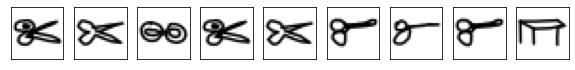

In [62]:
sequence = [1277, 820, 13549, 1277, 820, 5662, 5469, 5662, 25]

plt.figure(figsize=(10,6))
for i in range(len(sequence)):
    plt.subplot(1,len(sequence),i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[sequence[i]][:,:,0], cmap='gray')
plt.show()